### What is a Frequent Customer ?

Goal: To define and justify a data-driven threshold for “frequent customer,” exploring different definitions (transaction count, spend, recency, merchant context), and the impact on fraud rates.

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import matplotlib.pyplot as plt


RAW_DATA_PATH = './data/raw/'
DATA_FILE = 'transactions.csv'

df = pd.read_csv(os.path.join(RAW_DATA_PATH, DATA_FILE))

In [18]:
df.head()
df.describe(include='all')
df[['cc_num', 'merchant', 'amt', 'times_shopped_at_merchant_month', 'amt_month', 'is_fraud']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 6 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   amt                              float64
 3   times_shopped_at_merchant_month  int64  
 4   amt_month                        float64
 5   is_fraud                         int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 84.8+ MB


### Distribution of spend

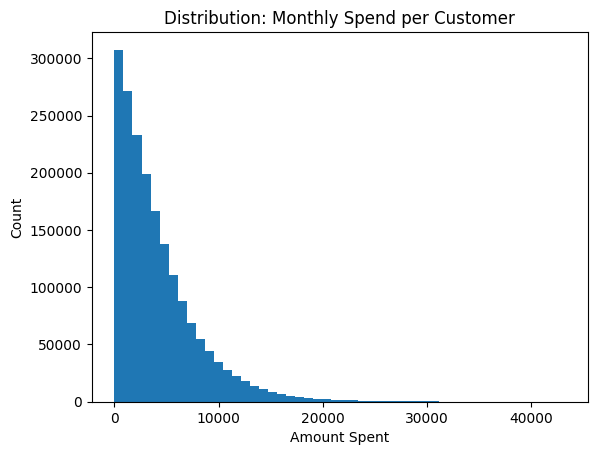

In [21]:
plt.hist(df['amt_month'], bins=50)
plt.title('Distribution: Monthly Spend per Customer')
plt.xlabel('Amount Spent')
plt.ylabel('Count')
plt.show()

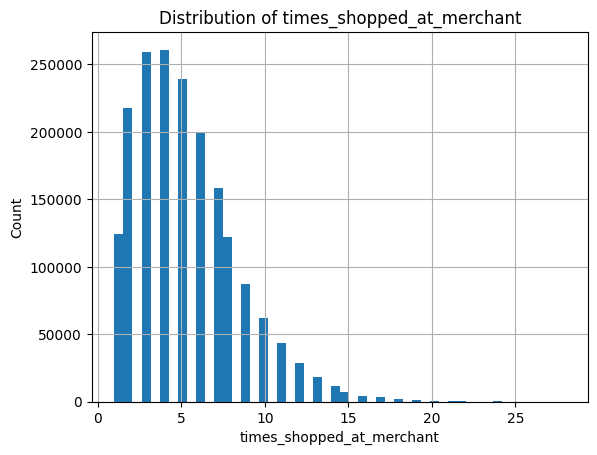

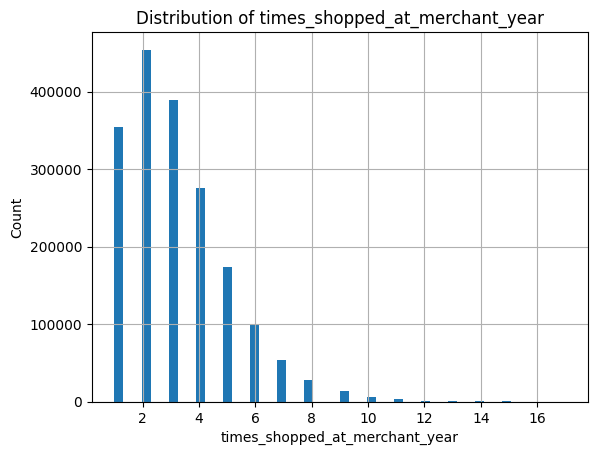

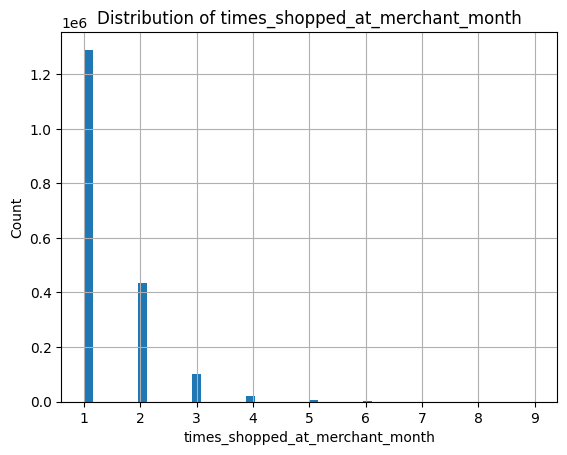

In [23]:

features = [
    'times_shopped_at_merchant',
    'times_shopped_at_merchant_year',
    'times_shopped_at_merchant_month'
]

for feature in features:
    plt.figure()
    df[feature].hist(bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


In [30]:
df['freq_bins'] = pd.cut(df['times_shopped_at_merchant_month'], bins=[1,2,3,4,5,6,7, np.inf], right=False)
print(df.groupby('freq_bins')['is_fraud'].mean() )

freq_bins
[1.0, 2.0)    0.005815
[2.0, 3.0)    0.003973
[3.0, 4.0)    0.003406
[4.0, 5.0)    0.002755
[5.0, 6.0)    0.003518
[6.0, 7.0)    0.002801
[7.0, inf)    0.000000
Name: is_fraud, dtype: float64


/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_27485/1889447673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('freq_bins')['is_fraud'].mean() )


In [31]:
df['spend_bins'] = pd.cut(df['amt_month'], bins=[0,50,100,200,500,1000,5000, np.inf], right=False)
print(df.groupby('spend_bins')['is_fraud'].mean())


spend_bins
[0.0, 50.0)         0.003751
[50.0, 100.0)       0.000352
[100.0, 200.0)      0.000423
[200.0, 500.0)      0.001578
[500.0, 1000.0)     0.001818
[1000.0, 5000.0)    0.004833
[5000.0, inf)       0.008089
Name: is_fraud, dtype: float64


/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_27485/3963037669.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('spend_bins')['is_fraud'].mean())


/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_27485/305292230.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('freq_bins')['is_fraud'].mean().plot(marker='o', title="Fraud Rate vs Frequency")


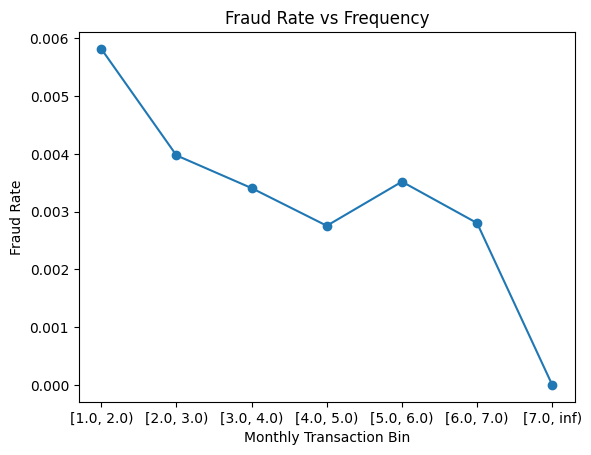

/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_27485/305292230.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('spend_bins')['is_fraud'].mean().plot(marker='o', title="Fraud Rate vs Monthly Spend")


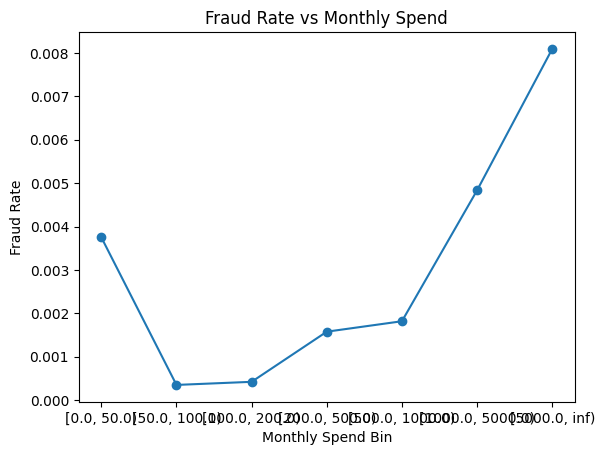

In [32]:
df.groupby('freq_bins')['is_fraud'].mean().plot(marker='o', title="Fraud Rate vs Frequency")
plt.xlabel('Monthly Transaction Bin')
plt.ylabel('Fraud Rate')
plt.show()

df.groupby('spend_bins')['is_fraud'].mean().plot(marker='o', title="Fraud Rate vs Monthly Spend")
plt.xlabel('Monthly Spend Bin')
plt.ylabel('Fraud Rate')
plt.show()


In [33]:
df['merchant_90th'] = df.groupby('merchant')['times_shopped_at_merchant_month'].transform(lambda x: x.quantile(0.9))
df['is_top10pct_merchant'] = (df['times_shopped_at_merchant_month'] >= df['merchant_90th']).astype(int)
print(df.groupby('is_top10pct_merchant')['is_fraud'].mean())


is_top10pct_merchant
0    0.005716
1    0.003843
Name: is_fraud, dtype: float64


In [35]:
summary = []
for rule, label in [
    (df['times_shopped_at_merchant_month'] >= 5, ">=5/month"),
    (df['is_top10pct_merchant'] == 1, "Top10% Merchant"),
    (df['amt_month'] >= 500, "Spent >= $500/month"),
]:
    subset = df[rule]
    summary.append({
        'Rule': label,
        'Num Transactions': len(subset),
        'Fraud Rate': subset['is_fraud'].mean(),
    })

import pandas as pd
pd.DataFrame(summary)


,Rule,Num Transactions,Fraud Rate
0,>=5/month,4868,0.003287
1,Top10% Merchant,500138,0.003843
2,Spent >= $500/month,1670606,0.005626


In [34]:
stats = df.groupby('merchant')['times_shopped_at_merchant_month'].agg(['median', 'std'])
df = df.merge(stats, left_on='merchant', right_index=True, how='left')
df['z_freq'] = (df['times_shopped_at_merchant_month'] - df['median']) / df['std']


In [ ]:
merchant_stats = (
    df.groupby('merchant')['times_shopped_at_merchant_month']
      .agg(['median', 'std'])
      .rename(columns={'median':'med_m_freq', 'std':'std_m_freq'})
)
df = df.merge(merchant_stats, on='merchant', how='left')
df

In [14]:
df['m_freq_z']   = (df['times_shopped_at_merchant_month'] - df['med_m_freq']) / df['std_m_freq']
df['top10_mfreq'] = (df['times_shopped_at_merchant_month'] >
                     df.groupby('merchant')['times_shopped_at_merchant_month']
                       .transform(lambda x: x.quantile(0.90))).astype(int)

In [38]:
for threshold in [3,4, 5, 7, 10]:

    count = (df['times_shopped_at_merchant_month'] >= threshold).sum()
    pct = 100 * count / len(df)
    print(f"Threshold {threshold}: {count} transactions ({pct:.2f}%) marked as frequent")


Threshold 3: 127210 transactions (6.87%) marked as frequent
Threshold 4: 25924 transactions (1.40%) marked as frequent
Threshold 5: 4868 transactions (0.26%) marked as frequent
Threshold 7: 174 transactions (0.01%) marked as frequent
Threshold 10: 0 transactions (0.00%) marked as frequent


In [36]:
tmp = (
    df.assign(freq_bin = (df['times_shopped_at_merchant_month'] >= 5).astype(int))
      .groupby(['merchant','freq_bin'])['is_fraud']
      .mean()
      .unstack()
      .dropna()
      .rename(columns={0:'<5',1:'>=5'})
)
(tmp['<5'] > tmp['>=5']).mean()


0.9609375